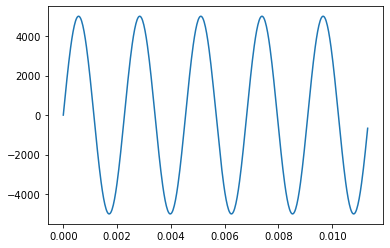

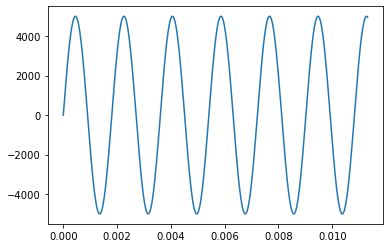

In [23]:
import numpy as np
import scipy.io.wavfile
import scipy.signal
import scipy
from remi_module.remi_module_import import *
import matplotlib.pyplot as plt

time = 3
f1 = 440
f2 = 554.37
f3 = 659.26
f4 = 880
f5 = 523.25
fs = 44100
t = np.arange(0, fs * time)
s1 = np.sin(2. * np.pi * f1 * t/fs) * 5000.
s2 = np.sin(2. * np.pi * f2 * t/fs) * 5000.
s3 = np.sin(2. * np.pi * f3 * t/fs) * 5000.
s4 = np.sin(2. * np.pi * f4 * t/fs) * 5000.
s5 = np.sin(2. * np.pi * f5 * t/fs) * 5000.

n = 500
plt.figure()
plt.plot(t[:n] / fs, s1[:n])
plt.show()
plt.figure()
plt.plot(t[:n] / fs, s2[:n])
plt.show()

In [27]:
RESULTS_PATH = "results/"

scipy.io.wavfile.write(RESULTS_PATH + "sin_1" + ".wav", fs, np.array(s1).astype(np.int16))
scipy.io.wavfile.write(RESULTS_PATH + "sin_2" + ".wav", fs, np.array(s2).astype(np.int16))
scipy.io.wavfile.write(RESULTS_PATH + "sin_3" + ".wav", fs, np.array(s3).astype(np.int16))
scipy.io.wavfile.write(RESULTS_PATH + "sin_4" + ".wav", fs, np.array(s4).astype(np.int16))
scipy.io.wavfile.write(RESULTS_PATH + "sin_5" + ".wav", fs, np.array(s5).astype(np.int16))

[   0.          313.24162089  625.25261847 ... -934.80720413 -625.25261848
 -313.24162089]


In [29]:
from pydub import AudioSegment

sin1 = AudioSegment.from_wav("results/sin_1.wav")
sin2 = AudioSegment.from_wav("results/sin_2.wav")
sin3 = AudioSegment.from_wav("results/sin_3.wav")
sin4 = AudioSegment.from_wav("results/sin_4.wav")
sin5 = AudioSegment.from_wav("results/sin_5.wav")
print(sin1)

y = sin1.overlay(sin2)
y = y.overlay(sin3)
y = y.overlay(sin4)
y = y.overlay(sin5)

y.export("results/sin_mix.wav", format="wav")

<_io.BufferedRandom name='results/sin_mix.wav'>

In [30]:
import sklearn.decomposition

(_, signal_an) = scipy.io.wavfile.read("results/sin_mix.wav")
(_, signal_n) = scipy.io.wavfile.read("results/sin_2.wav")
print(signal_an)

nperseg = 2048

from scipy.fft import fft, ifft
import scipy
import librosa

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.signal.windows.hann(framesamp)
    X = np.array([fft(w*x[i:i+framesamp])
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = np.zeros(T)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += np.real(ifft(X[n]))
    return x

print(signal_an.shape)
print(signal_an)
_, _, Zxx_an = scipy.signal.stft(signal_an, fs, nperseg=nperseg)
ttt = librosa.core.stft(signal_an)
print(librosa.core.istft(ttt).shape, np.linalg.norm(signal_an - librosa.core.istft(ttt * np.angle(ttt))))

_, _, Zxx_n = scipy.signal.stft(signal_n, fs, nperseg=nperseg)

AICs = []
xs = np.arange(300, 351)

N = Zxx_n.shape[1] * Zxx_n.shape[0]
print(np.min(Zxx_n))

NMFs = []
NMFs_sum = []
for n_components in xs:
    #W, H = NMF(np.absolute(Zxx_an), n_components=n_components, max_iter=500, err=0.1)
    model_train = sklearn.decomposition.NMF(n_components=n_components, init='random', random_state=0, max_iter=100000)
    W = model_train.fit_transform(abs(Zxx_n))
    H = model_train.components_

    # AICs.append(2 * n_components + N * np.log(pow(np.linalg.norm(np.absolute(Zxx_n) - W @ H), 2.0)  / N))
    AICs.append(2 * n_components * (Zxx_n.shape[0] + Zxx_n.shape[1] - 1) + N * np.log(pow(np.linalg.norm(np.absolute(Zxx_n) - W @ H), 2.0)  / N))

    print(str(n_components) + " " + str(AICs[-1]))
    NMFs_sum.append(np.sum(abs(Zxx_n) - W @ H))
    NMFs.append(np.linalg.norm(abs(Zxx_n) - W @ H))


print("MIN AIC = " + str(np.min(AICs)) + " id : " + str(np.argmin(AICs)))
plt.figure()
plt.plot(xs, AICs)
plt.show()

plt.figure()
plt.title("NMF over k")
plt.plot(xs, NMFs)
plt.show()

plt.figure()
plt.plot(xs, NMFs_sum)
plt.show()



AICs = []
xs = np.arange(1, 51)

N = Zxx_an.shape[1] * Zxx_an.shape[0]

for n_components in xs:
    W1, H1, W2, H2, ress = SSNMF(abs(Zxx_an), W, n_components=n_components, max_iter=100, err=0.1)
    # AICs.append(2 * n_components + N * np.log(pow(np.linalg.norm(abs(Zxx_an) - (W1 @ H1 + W2 @ H2)), 2.0)  / N))

    AICs.append(2 * n_components * (Zxx_an.shape[0] + Zxx_an.shape[1] - 1) + N * np.log(pow(np.linalg.norm(np.absolute(Zxx_an) - (W1 @ H1 + W2 @ H2)), 2.0)  / N))


phase = np.angle(Zxx_an)

s = W2 @ H2
s = s * phase
X = scipy.signal.istft(s, fs, nperseg=nperseg)[1]
scipy.io.wavfile.write(RESULTS_PATH + "signal" + ".wav", fs, np.array(X).astype(np.int16))

s = W1 @ H1
s = s * phase
X = scipy.signal.istft(s, fs, nperseg=nperseg)[1]
scipy.io.wavfile.write(RESULTS_PATH + "bruit" + ".wav", fs, np.array(X).astype(np.int16))

print("MIN AIC = " + str(np.min(AICs)) + " id : " + str(np.argmin(AICs)))
plt.figure()
plt.plot(xs, AICs)
plt.show()


plt.figure()
plt.plot(ress)
plt.show()

print(W1)

plt.figure()
plt.title("Spectrogram")
plt.pcolormesh(W1)
plt.colorbar()
plt.show()

[     0   2172   4326 ... -10430  -9267  -8028]
(132300,)
[     0   2172   4326 ... -10430  -9267  -8028]


ParameterError: Audio data must be floating-point

In [ ]:


phase = np.angle(Zxx_an)
for j in range(n_components):

    s = np.outer(W[:,j],(H[j,:]))
    s = s * phase
    # print(len(scipy.signal.istft(s, fe_an)))
    Y = scipy.signal.istft(s, fs)[1]

    plt.figure()
    plt.title("Activation " + str(j))
    plt.plot(H[j,:])
    plt.show()

    scipy.io.wavfile.write(RESULTS_PATH + "res_0_" + str(j) + ".wav", fs, np.array(Y).astype(np.int16))